<a href="https://colab.research.google.com/github/Hgherzog/TTIC-DeepLearning/blob/main/Henry_Herzog_PS3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instructions

As in the previous assignment, youl'll be using PyTorch instead of EDF. This assignment will focus on generative modelling, and you'll implement and train a VAE and a GAN.

It is highly suggested to use google colab and run the notebook on a GPU node.
Check https://colab.research.google.com/ and look for tutorials online on how to use it. To use a GPU go to Runtime -> Change runtime type and select GPU.

In [ ]:
import torch, math, copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from scipy.stats import kde
import matplotlib.pyplot as plt

We'll start by coding up a toy problem and seeing how a VAE and a GAN behave on it. Consider the following stochastic process:
$$ \mu_x \sim U(\{1,2,3\})$$
$$ \mu_y \sim U(\{1,2,3\})$$
$$ s \sim \mathcal N \left([\mu_x, \mu_y], \frac{1}{100}I \right)$$
where $I$ is the $2 \times 2$ identity matrix.

Implement the function in the next cell such that it returns $n$ samples distributed as $s$ from the above process. The returned object should be a $n \times 2$ PyTorch tensor.

In [ ]:
#want to sample from a distribution that is uniform over 1,2,3 and use that as the mean
def sample(n):
  m_xy = torch.randint(1, 4, (n, 2), dtype=torch.float32)
  std = 0.1*torch.ones(n, 2)
  s = torch.normal(m_xy, std) 
  return s

Now we'll sample 1000 points and see how they are distributed.

In [ ]:
def plot_density(data):
    data = data.numpy()
    nbins = 50
    x, y = data.T
    k = kde.gaussian_kde(data.T)
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)

    plt.tight_layout()
    plt.show()
    plt.clf()

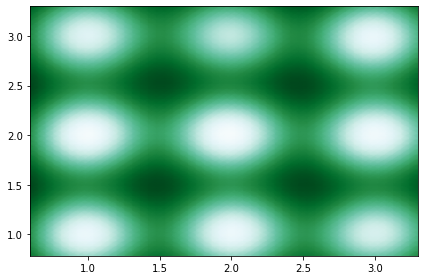

<Figure size 432x288 with 0 Axes>

In [ ]:
data = sample(1000)
plot_density(data)

## VAE on a Toy Problem

Recall that when training a VAE we're concerned with the following problem:

$$\min_{\phi} \,\ \mathbb E_{x \sim Pop, z \sim P_\phi(z|x)} \left[ \ln \frac{P_\phi(z|x)}{P(z)} - \ln P_\phi(x|z) \right] \,.$$

We'll model $P_\phi(z|x)$ with an encoder and $P_\phi(x|z)$ with a decoder as follows:
$$P_\phi(z|x) = \mathcal N \left(\mu_{\phi,z}(x), \Sigma_{\phi,z}(x) \right)$$
$$P_\phi(x|z) = \mathcal N \left( \mu_{\phi,x}(z), \sigma^2 I \right) \,,$$
where $\mu_{\phi,z}, \Sigma_{\phi,z}, \mu_{\phi,x}$ are neural networks, and $\Sigma_{\phi,z}(x)$ is diagonal.

Moreover, let $P(z)$ (the prior over $z$) to be $\mathcal N(0, I)$.


**<span style="color:blue">
    For the above distributions, what is $\ln P_\phi(x|z)$ as a function of $x, z, \mu_{\phi,x}$, and $\sigma$?
</span>**

**<span style="color:red">
    $\ln P_\phi(x|z)$ = = -(x-\mu_{\phi,x}(z))^2/(2\sigma^2) + lnd
</span>**

**<span style="color:red">
    ------------------------------------------------------------------------------- ANSWER (END) -------------------------------------------------------------------------------
</span>**

**<span style="color:blue">
    For the above distributions, what is $\ln \frac{P_\phi(z|x)}{P(z)}$ as a function of $x, z, \mu_{\phi,z}, \Sigma_{\phi,z}$?
</span>**
Let d be the proportionality constant for the gaussian
**<span style="color:red">

    $\ln \frac{P_\phi(z|x)}{P(z)}$ = lnd - (z - \mu_{\phi,z})^2 / (2\Sigma_{\phi,z}(x)^2) + z^2/2
</span>**

**<span style="color:red">
    ------------------------------------------------------------------------------- ANSWER (END) -------------------------------------------------------------------------------
</span>**

We are almost ready to set up a VAE network in PyTorch and train it. The following cell has an incomplete implementation of a VAE. The encoder and decoder networks are already defined (note that the encoder outputs $\log \Sigma$ instead of $\Sigma$, which is standard practice since otherwise we have to guarantee that the covariance matrix is non-negative). latent_dim is the dimensionality of the latent variable $z$.

Complete the implementations of encode, sample, and decode.
The encode method receives samples $x$ and has to return the mean vector $\mu_z(x)$ and the element-wise log of the diagonal of $\Sigma_z(x)$. The self.encoder network already maps $x$ to a 50-dim vector, and the self.mu, self.logvar modules can be used to map this 50-dim vector to the mean vector and the log diag of the covariance matrix.

The sample method receives mu and logvar (the outputs of encode) and has to return samples from the corresponding Gaussian distribution. Here we typically employ the reparameterization trick, where we can draw a sample $s \sim \mathcal N(\mu, \sigma)$ by doing $s = \mu + \sigma \cdot \epsilon, \epsilon \sim \mathcal N(0, 1)$, which yields well-defined gradients that autograd takes care of computing.

Finally, the decode method takes $z$ as input and should return $\mu_x(z)$. You should use the self.decodet module for this.

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(2, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU()
        )

        self.mu = nn.Linear(50, latent_dim)
        self.logvar = nn.Linear(50, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def encode(self, x):
        # implementation goes here
        x_enc = self.encoder(x)
        mu = self.mu(x_enc) 
        logvar = self.logvar(x_enc)
        return mu, logvar
    
    def sample(self, mu, logvar):
        # implementation goes here need to add shape and change to element wise
        epsilon = torch.normal(torch.zeros_like(mu), torch.ones_like(logvar))
        z = torch.add(mu, torch.mul(torch.sqrt(torch.exp(logvar)), epsilon))
        return z
    
    def decode(self, z):
        # implementation goes here
        out = self.decoder(z)
        return out
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.sample(mu, logvar)
        out = self.decode(z)
        return mu, logvar, out
    
    def generate(self, n):
        z = torch.randn(n, self.latent_dim).cuda()
        samples = self.decode(z)
        return samples

Finally, implement the loss of the VAE by using the equations you derived previously. The recon_loss term should have the factor corresponding to $P(x|z)$, while kld_loss should have the KL divergence term.

In your derivation $\sigma$ hopefully showed up as a weight between the two terms. Here we'll use the standard beta-VAE notation and apply a weight beta on the KL divergence term instead.

In [ ]:
def loss(x, out, mu, logvar, beta):
    recons_loss = torch.mean(0.5 * torch.sum(torch.square(x-out)))
    kld_loss = -0.5*torch.mean(torch.sum(1 +logvar -  torch.square(mu) - torch.exp(logvar)))
    loss = recons_loss + beta * kld_loss
    return recons_loss, kld_loss, loss

We can then train the VAE on the toy problem and see how it performs.
Try different values of beta until you find one that yields good results.

In [ ]:
vae = VAE(100).cuda()
opt = torch.optim.Adam(vae.parameters(), lr=5e-4)

At beta= 0


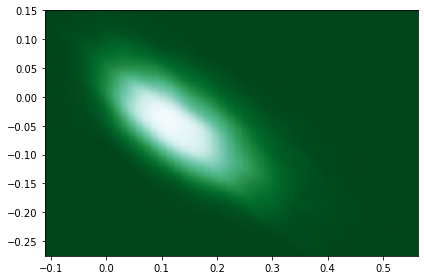

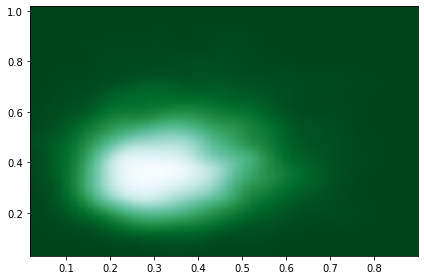

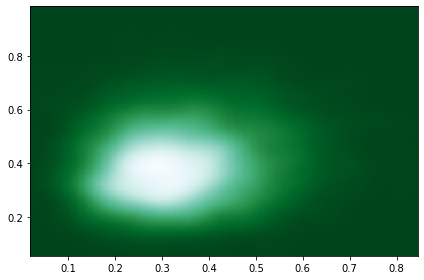

At beta= 0.01


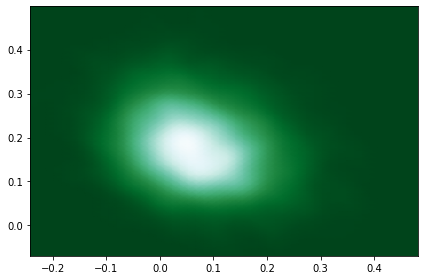

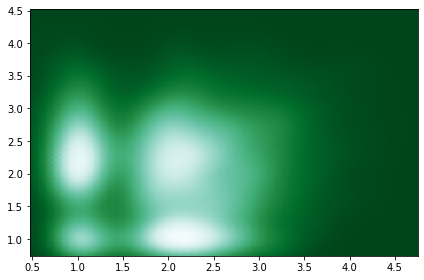

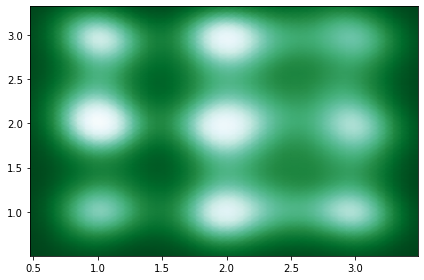

At beta= 0.04


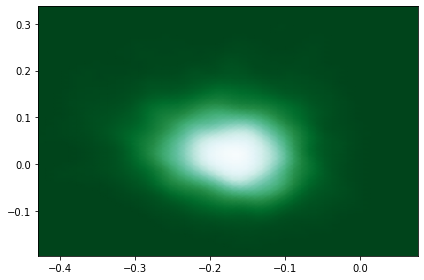

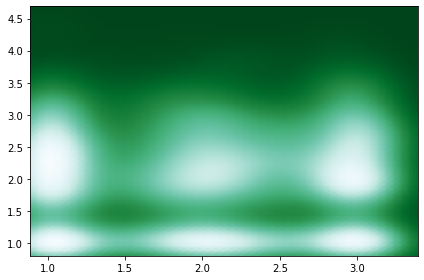

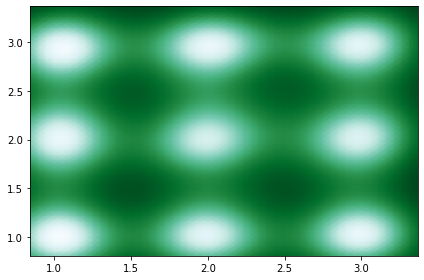

At beta= 0.1


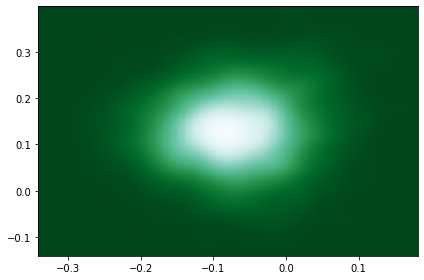

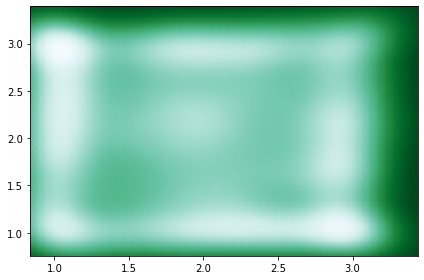

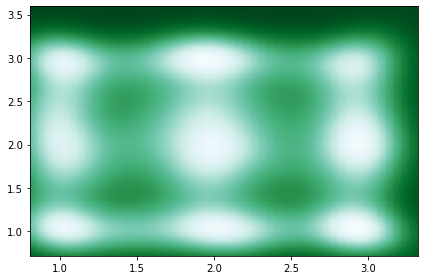

At beta= 1.0


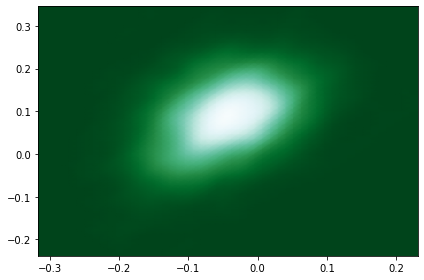

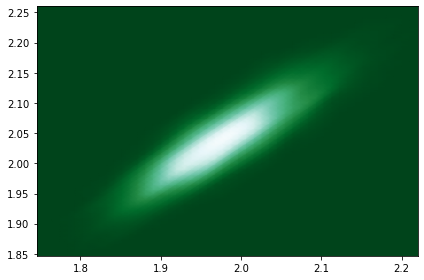

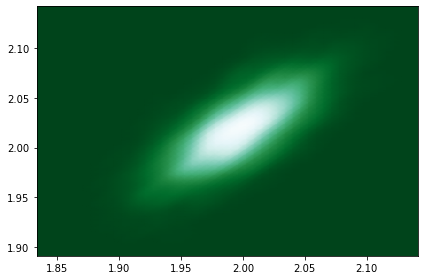

At beta= 100


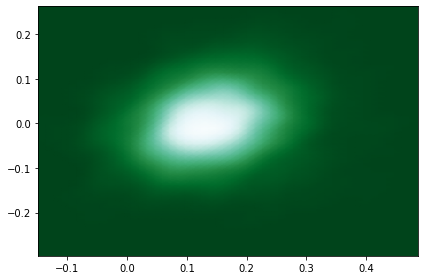

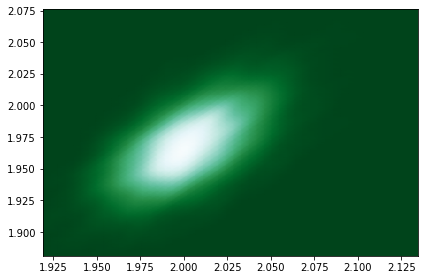

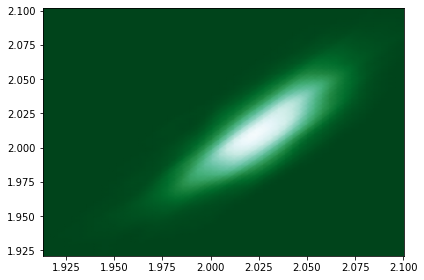

<Figure size 432x288 with 0 Axes>

In [ ]:
beta_vals = [0, 0.01, 0.04, 0.1, 1.0, 100]
for beta in beta_vals:
  vae = VAE(100).cuda()
  opt = torch.optim.Adam(vae.parameters(), lr=5e-4)
  print("At beta=", beta)
  for i in range(20001):
      s = sample(128).cuda()
      mu, logvar, out = vae(s)
      rl, kl, l = loss(s, out, mu, logvar, beta)
      opt.zero_grad()
      l.backward()
      opt.step()
      if i % 10000 == 0:
          data = vae.generate(5000)
          plot_density(data.cpu().data)

**<span style="color:blue">
    How does beta affect the performance of the VAE? Show or discuss what tradeoff beta controls, and how this can be observed from the above plots and/or any additional plots.
</span>**

Beta controls the tradeoff between generating real looking data vs how close the predictions of the latent variable are to the prior on z, which is in this case a unit gaussian. Generally, larger beta values incentivise the latent distribution to be more structured, while small beta values incentivise the generated data to look closer to real data. This can be seen in the above distributions as beta increeases.


If we make Kl dominate distribution does not move but becomes increasingly circular and structured, for the latent varaible. This can be seen in the beta = 100

If we let Recon dominate, then the distirbution moves closer to the distirbution of the original stochastic process but has a highly unstructured latent variable. This can be seen from the good recreations that come from low beta values.

If we let beta=0, however, the recreation of the distribution is bad because the latent distribution is completely unstructured.
**<span style="color:red">
    ------------------------------------------------------------------------------- ANSWER (BEGIN) -------------------------------------------------------------------------------
</span>**

**<span style="color:red">
    ------------------------------------------------------------------------------- ANSWER (END) -------------------------------------------------------------------------------
</span>**

## GAN

Recall the GAN objective
$$\min_\psi \max_\phi \,\ \mathbb E_{x \sim Pop}[ -\ln P_\psi(1 | x) ] + \mathbb E_{z \sim \mathcal N(0,1)} [- \ln P_\psi(0|G_\phi(z))  ] \,,$$
where $G_\phi$ is a network that maps gaussian noise $z \sim \mathcal N(0,1)$ to $G(z)$ with the same shape as $x$, and $P_\psi$ is modeled by another network (the discriminator) that maps real samples $x$ and 'fake' samples $G(z)$ to a distribution over $\{0,1\}$.

We will follow the common practice of adopting a different objective for the generator network $G$:
$$\min_\phi \,\ \mathbb E_{z \sim \mathcal N(0,1)} [- \ln P_\psi(1|G_\phi(z))  ] \,.$$

First, complete the implementation of the Generator module below. The forward method takes an integer $n$ as input and should return $n$ samples $G(z), z \sim \mathcal N(0, I)$, each with dimensionality 2. You should use the self.network module for the mapping $G$.

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim

        self.network = nn.Sequential(
            nn.Linear(latent_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def decode(self, input):
        out = self.network(input)
        return out

    def forward(self, n):
        z = torch.normal(torch.zeros(n, self.latent_dim), torch.ones(n, self.latent_dim)).to("cuda")
        samples = self.network(z)
        return samples

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(2, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )
    
    def forward(self, input):
        out = self.network(input)
        return out

In [ ]:
generator = Generator(100).cuda()
gopt = torch.optim.Adam(generator.parameters(), lr=5e-4, betas=(0.5, 0.999))
discriminator = Discriminator().cuda()
dopt = torch.optim.Adam(discriminator.parameters(), lr=5e-4, betas=(0.5, 0.999))
criterion = torch.nn.BCEWithLogitsLoss()


Now, you'll implement the training procedure for GANs. In each iteration of the for loop below we'll update the parameters of the generator and then update the discriminator.

Fill up the missing code below. You should rely on the objective given previously to define the loss of the generator and the discriminator (both the function, the data inputs, and the target labels).

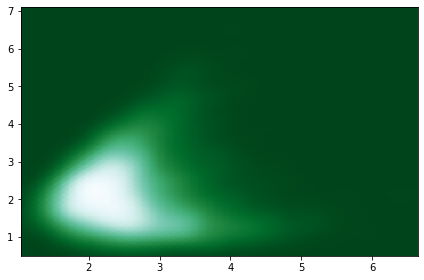

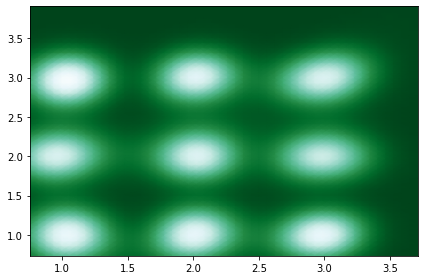

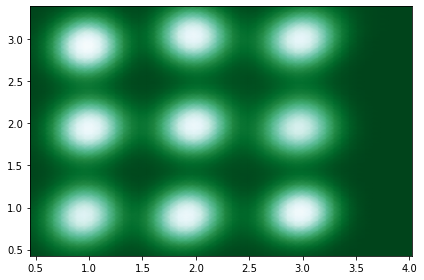

<Figure size 432x288 with 0 Axes>

In [ ]:
Tensor = torch.cuda.FloatTensor
for i in range(20001): 
    #Train Generator 
    n = 5000
    #Generate distribution from noise
    gen_dist = generator(n)
    gen_dist = gen_dist.cuda()
    out_disc = discriminator(gen_dist)
    real = Tensor(n,1).fill_(1.0)
    fake = Tensor(n,1).fill_(0.0)
    g_l = criterion(out_disc, real)
    gopt.zero_grad()
    g_l.backward() 
    gopt.step()
    # Train Discriminator
    #Sample True distribution
    real_dist = sample(n)
    real_dist = real_dist.cuda()
    real_out = discriminator(real_dist)
    #Generate Fake distribution
    fake_input = generator(n)
    fake_out = discriminator(fake_input)
    real_loss = criterion(real_out, real)
    fake_loss = criterion(fake_out, fake) 
    d_l = (real_loss + fake_loss) / 2.0
    dopt.zero_grad()
    d_l.backward()
    dopt.step()

    
    
    if i % 10000 == 0:
        data = generator(5000)
        plot_density(data.cpu().data)

**<span style="color:blue">
    Compare and discuss the results you obtained with the VAE and with the GAN approach.
</span>**

**<span style="color:red">
    The distributions generated by the GAN was much sharper as the white spots were more tightly concentrated along the possible means of the real distribution. This is due to the fact that the GAN is not sampling noise and is only sampling from an implicit distribution. On the other hand, the distributions generated by the VAE are noisier and thus seem to more accurately represent the initial ditribution. This is because the VAE is learning an explicit distribution that is sampling from. Also, the VAE tends to has a less sharp output because the latent dimension acts as a bottleneck on the information passing through the network. Overall, I obtained pretty accurate results for both the GAN and the VAE and observed the GAN produced sharper results but the VAE, with optimized beta, more closely modeled the true distribution.
</span>**

**<span style="color:red">
    ------------------------------------------------------------------------------- ANSWER (END) -------------------------------------------------------------------------------
</span>**

## VAE and GANs on CelebA/MNIST

In this second part of the assignment you'll train a VAE and a GAN on a more interesting dataset. The cell below will try to download and load CelebA, and will just load MNIST in case there is an error.

It is likely that you'll get an error when trying to download CelebA since the its google drive is always out of quota. If you'd like to use CelebA anyway, you can try to download it from here http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html or some other source. If you're not running this notebook on a GPU then use MNIST instead.

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(64), transforms.CenterCrop(64), transforms.Normalize((0.5,), (0.5,))])
try:
    dataset = datasets.CelebA("data", split='all', download=True, transform=transform)
    is_celeb = 1
except:
    dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
    is_celeb = 0
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



We'll use a a CNN for the VAE instead of the simple model we defined previously.
Implement a network following these specifications:

- Encoder. Should have 4 conv layers, each with kernel size 4, stride 2 and padding 1, which decrease the spatial resolution by half. The output of the 4th conv (a spatial res. 4x4) should be flattened and then fully connected layers should be used to compute mu and logvar. Add whichever activation function you prefer between the conv layers (ReLU, LeakyReLU, ELU, etc), and feel free to add batch norm as well. Let the first conv layer have, say, 8 or 16 channels and then double the number of channels at each following conv layer.

- Decoder. Try to have an architecture that is roughly symmetric to the encoder. For example, start with a fully connected layer to project the latent_dim dimensional input such that you end up wuth a (128*4*4)-dimensional vector that you can reshape into a 4x4 image. Then you can apply 4 transposed conv layers, e.g. with kernel size 4, stride 2 and padding 1, to double the spatial resolution with each layer, having a final output of size 64x64. Start with around 64 or 128 channels for the first transposed conv and then halve the number of channels at each following conv layer. As before, add your preferred activation function between layers, with or without batch norm.

The encode, sample, and decode methods have the same specification as before.

In [ ]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim
        self.act = nn.LeakyReLU()
        if is_celeb:
          c = 3
        else:
          c = 1
        self.encoder = nn.Sequential(
            nn.Conv2d(c, 8, 4 , 2, 1),
            self.act,
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, 4 , 2, 1),
            self.act,
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 4 , 2, 1),
            self.act,
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 4 , 2, 1),
            self.act,
            #TODO: Change this so we are flattening each image and not the batch of images
            nn.Flatten(1),
            # self.act
        )
        #To-do get a value for every one in the batch
        self.mu = nn.Linear(1024, latent_dim)
        self.logvar = nn.Linear(1024, latent_dim)
        self.linear_dec = nn.Sequential(nn.Linear(latent_dim, 1024),
            self.act)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            self.act,
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            self.act,
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 8, 4, 2, 1),
            self.act,
            nn.BatchNorm2d(8),
            nn.ConvTranspose2d(8, c, 4, 2, 1),
            self.act,
        )
        
    def encode(self, input):
        #input is a batch of images
        x_enc = self.encoder(input)
        #Should each encoded input have there own predicted mu/logvar or how do we get mu/logvar
        mu = self.mu(x_enc)
        logvar = self.logvar(x_enc)
        return mu, logvar
    
    def sample(self, mu, logvar):
        eps = torch.normal(torch.zeros_like(mu), torch.ones_like(logvar))
        std = torch.sqrt(torch.exp(logvar))
        mu = torch.atleast_2d(mu)
        return eps * std + mu
    
    def decode(self, input):
        num_img = input.size(0)
        latent_im = self.linear_dec(input)
        latent_im_batch = torch.reshape(latent_im, (num_img,64,4,4))
        out = self.decoder(latent_im_batch)
        return out
        
    def forward(self, input):
        mu, logvar = self.encode(input)
        z = self.sample(mu, logvar)
        out = self.decode(z)
        return mu, logvar, out
    
    def generate(self, n):
        #generates n images
        z = torch.randn(n, self.latent_dim).cuda()
        samples = self.decode(z)
        return samples

In [ ]:
vae = ConvVAE(100).cuda()
opt = torch.optim.Adam(vae.parameters(), lr=5e-4)

The cell below applies a 'patch' in case you're using google colab (cv2_imshow doesn't work properly on google colab without it). Feel free to comment out the first import if you're not using google colab (you might have to add from cv2 import cv2_imshow, though).

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

def show(x):
    img = x.data.cpu().permute(1, 2, 0).numpy() * 255
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2_imshow(img)

Again, try to find a value for beta that yields reasonable results.

Generation:


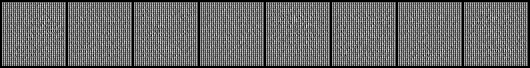

Generation:


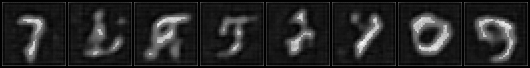

In [ ]:
#Did beta =1 Kept running out of GPU so only could save 1 epoch
beta = 1.0
for epoch in range(100):
    for i, x in enumerate(loader):
        if len(x) == 2:
            x = x[0]
        x = x.cuda()
        mu, logvar, out = vae(x)
        rl, kl, l = loss(x, out, mu, logvar, beta)

        opt.zero_grad()
        l.backward()
        opt.step()
        if i  == 0 and epoch % 10 == 0:
            vae.eval()
            print("Generation:")
            data = vae.generate(8)
            grid_img = torchvision.utils.make_grid(data, nrow=8, normalize=True)
            show(grid_img)
            vae.train()

You'll also re-implement the Generator and Discriminator modules for the GAN, adopting a CNN-like architecture.

For the generator, implement a network similar to the one you used for the VAE decoder (fully connected for projection followed by 4 transposed convolutions), while for the discriminator you should use a network similar to the VAE encoder (4 conv layers with stride 2, but note that the output should be a scalar per image, not a latent vector).

In [ ]:
class ConvGenerator(nn.Module):
    def __init__(self, latent_dim):
        super(ConvGenerator, self).__init__()
        self.latent_dim = latent_dim
        self.act = nn.LeakyReLU(0.2)
        self.lin_act = nn.Sequential(nn.Linear(latent_dim, 1024), self.act)
        if is_celeb:
          c = 3
        else:
          c = 1
        self.network = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            self.act,
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            self.act,
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 8, 4, 2, 1),
            self.act,
            nn.BatchNorm2d(8),
            nn.ConvTranspose2d(8, c, 4, 2, 1),
            # nn.Tanh()
        )

    def decode(self, input):
        num_imgs = input.size(0)
        latent_im = self.lin_act(input)
        latent_im_batch = torch.reshape(latent_im, (num_imgs, 64,4,4))
        out = self.network(latent_im_batch)
        return out

    def forward(self, n):
        z = torch.randn(n, self.latent_dim).cuda()
        samples = self.decode(z)
        return samples

In [ ]:
class ConvDiscriminator(nn.Module):
    def __init__(self, latent_dim):
        super(ConvDiscriminator, self).__init__()
        self.act = nn.LeakyReLU(0.2)
        if is_celeb:
          c = 3
        else:
          c = 1
        self.network = nn.Sequential(
            nn.Conv2d(c, 8, 4 , 2, 1),
            self.act,
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, 4 , 2, 1),
            self.act,
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 4 , 2, 1),
            self.act,
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 4 , 2, 1),
            self.act,
            nn.Flatten(1),
            nn.Linear(1024, 1),
            # nn.Tanh()
        )
    
    def forward(self, input):
        out = self.network(input)
        return out

In [ ]:
generator = ConvGenerator(100).cuda()
gopt = torch.optim.Adam(generator.parameters(), lr=5e-4, betas=(0.5, 0.999))
discriminator = ConvDiscriminator(100).cuda()
dopt = torch.optim.Adam(discriminator.parameters(), lr=5e-4, betas=(0.5, 0.999))
criterion = torch.nn.BCEWithLogitsLoss()

tensor(0.7636, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.4574, device='cuda:0', grad_fn=<AddBackward0>)
Generation at Epoch:  0


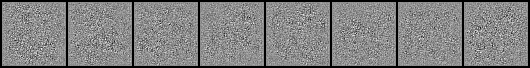

tensor(0.4392, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.6541, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5390, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.4456, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5314, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.3731, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9667, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.9057, device='cuda:0', grad_fn=<AddBackward0>)
Generation at Epoch:  1


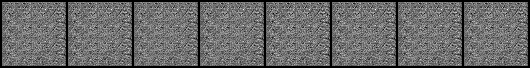

tensor(0.6614, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.4902, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7726, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.3529, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6777, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.3962, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9577, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.1228, device='cuda:0', grad_fn=<AddBackward0>)
Generation at Epoch:  2


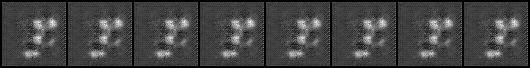

tensor(0.5902, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.6213, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8714, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.2244, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8271, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.3572, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7243, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.4175, device='cuda:0', grad_fn=<AddBackward0>)
Generation at Epoch:  3


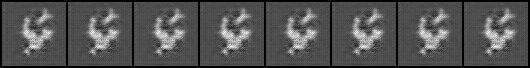

tensor(0.8051, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.2577, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5513, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.6031, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5987, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.5305, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7402, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.5241, device='cuda:0', grad_fn=<AddBackward0>)
Generation at Epoch:  4


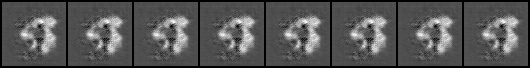

tensor(0.8508, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.2420, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6835, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.5196, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8668, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.3087, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6748, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.2733, device='cuda:0', grad_fn=<AddBackward0>)
Generation at Epoch:  5


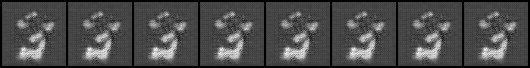

tensor(0.8650, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.0633, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7768, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.4471, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7201, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.3358, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1727, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.9511, device='cuda:0', grad_fn=<AddBackward0>)
Generation at Epoch:  6


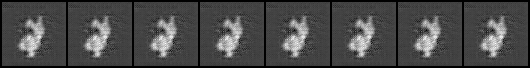

tensor(1.2349, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.8984, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8929, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6485, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.2969, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6874, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1750, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6101, device='cuda:0', grad_fn=<AddBackward0>)
Generation at Epoch:  7


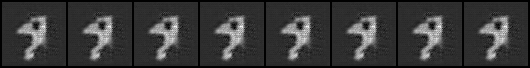

tensor(1.4184, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.3824, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4305, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4688, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4034, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3931, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7868, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.1608, device='cuda:0', grad_fn=<AddBackward0>)
Generation at Epoch:  8


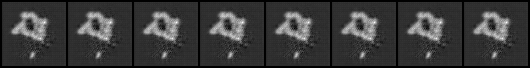

tensor(0.7519, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.1665, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3602, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4326, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2934, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.9791, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.8342, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3386, device='cuda:0', grad_fn=<AddBackward0>)
Generation at Epoch:  9


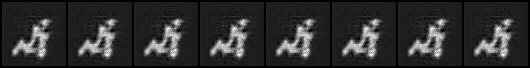

tensor(1.1586, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.9280, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7398, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2380, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.4519, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4137, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.8549, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(2.7400, device='cuda:0', grad_fn=<AddBackward0>)
Generation at Epoch:  10


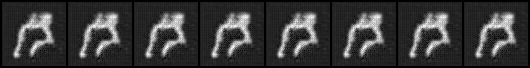

tensor(1.5618, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5191, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.0292, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3295, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4219, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3598, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.3411, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.9907, device='cuda:0', grad_fn=<AddBackward0>)
Generation at Epoch:  11


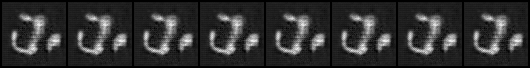

tensor(2.6553, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5934, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0585, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5868, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5893, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4104, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.4788, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2040, device='cuda:0', grad_fn=<AddBackward0>)
Generation at Epoch:  12


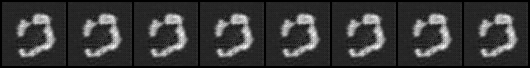

tensor(2.9425, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3583, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.5886, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3113, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.1322, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0518, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.2253, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1804, device='cuda:0', grad_fn=<AddBackward0>)
Generation at Epoch:  13


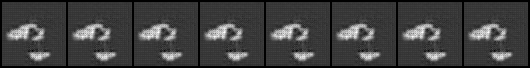

tensor(2.5579, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1357, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.4679, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5124, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.1208, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4826, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.5879, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1338, device='cuda:0', grad_fn=<AddBackward0>)
Generation at Epoch:  14


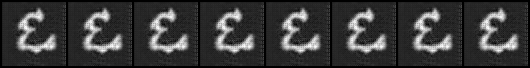

tensor(3.8572, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2688, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.2790, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2293, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.1971, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1731, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.4444, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0769, device='cuda:0', grad_fn=<AddBackward0>)
Generation at Epoch:  15


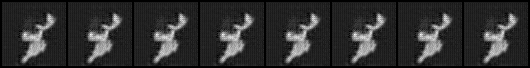

tensor(1.6634, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2607, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.1405, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2256, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5925, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.7089, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.6530, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2074, device='cuda:0', grad_fn=<AddBackward0>)
Generation at Epoch:  16


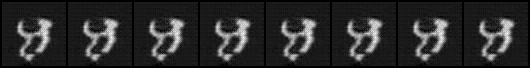

tensor(3.0321, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1931, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.6669, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2444, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.7306, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3024, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.7232, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.2418, device='cuda:0', grad_fn=<AddBackward0>)
Generation at Epoch:  17


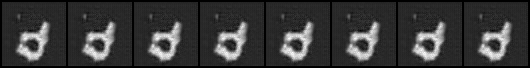

tensor(2.3134, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1890, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.1228, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1453, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.5144, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.6316, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1083, device='cuda:0', grad_fn=<AddBackward0>)
Generation at Epoch:  18


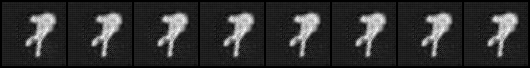

tensor(3.5725, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1092, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.1335, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0929, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.3798, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3979, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.3459, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0376, device='cuda:0', grad_fn=<AddBackward0>)
Generation at Epoch:  19


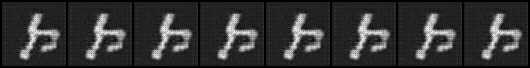

tensor(3.5236, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0385, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.7161, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1117, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5536, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.0104, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.2651, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4425, device='cuda:0', grad_fn=<AddBackward0>)
Generation at Epoch:  20


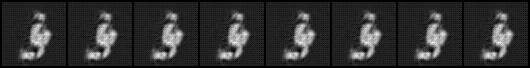

tensor(1.8006, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5489, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.1891, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3557, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.3915, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0547, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3354, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3477, device='cuda:0', grad_fn=<AddBackward0>)
Generation at Epoch:  21


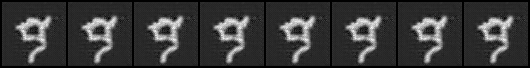

tensor(3.0868, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1189, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.6449, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2868, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.6217, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0284, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.7813, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0344, device='cuda:0', grad_fn=<AddBackward0>)
Generation at Epoch:  22


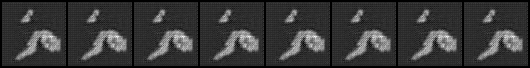

tensor(4.7334, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0268, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.3250, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2789, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.6813, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0716, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.7654, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0926, device='cuda:0', grad_fn=<AddBackward0>)
Generation at Epoch:  23


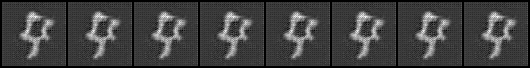

tensor(1.7903, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3111, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.9103, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.3134, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.8545, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1100, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.1752, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1132, device='cuda:0', grad_fn=<AddBackward0>)
Generation at Epoch:  24


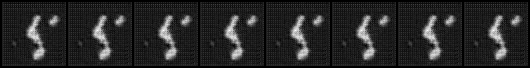

tensor(3.0480, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2402, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.6353, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0805, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.9597, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0229, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.0752, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1074, device='cuda:0', grad_fn=<AddBackward0>)
Generation at Epoch:  25


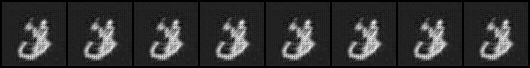

tensor(4.4740, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0074, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.8981, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1669, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.5419, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1332, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.0601, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0500, device='cuda:0', grad_fn=<AddBackward0>)
Generation at Epoch:  26


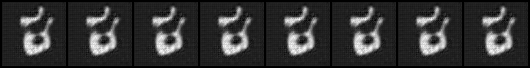

tensor(0.7259, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.9862, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.0096, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1728, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.4294, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1058, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.9822, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2633, device='cuda:0', grad_fn=<AddBackward0>)
Generation at Epoch:  27


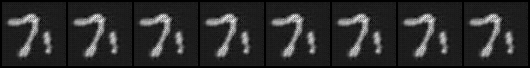

tensor(4.3670, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0675, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.5147, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.2544, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.9846, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1551, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.2258, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1375, device='cuda:0', grad_fn=<AddBackward0>)
Generation at Epoch:  28


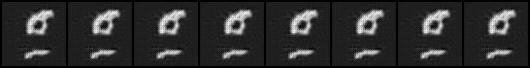

tensor(4.0872, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0555, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.3310, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1091, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.5304, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0616, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.2625, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0349, device='cuda:0', grad_fn=<AddBackward0>)
Generation at Epoch:  29


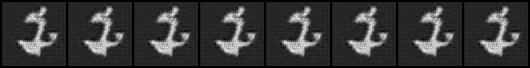

tensor(3.2660, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0968, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.8872, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.4370, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.6128, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1315, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.3996, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.0364, device='cuda:0', grad_fn=<AddBackward0>)
Generation at Epoch:  30


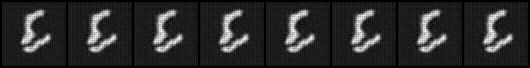

tensor(3.1485, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1521, device='cuda:0', grad_fn=<AddBackward0>)


KeyboardInterrupt: ignored

In [ ]:
for epoch in range(100):
    for i, x in enumerate(loader):
        if len(x) == 2:
            x = x[0]
        x = x.cuda()
        #is the issue here that discriminator(x) should be a batch_size x 1 tensor am I doing the batches correctly?
        n = 8
        real_labels = torch.ones(n, 1).cuda()
        fake_labels = torch.zeros(n, 1).cuda()
        # Train G
        gen_img = generator(n)
        output = discriminator(gen_img)
        # print(output.size()) #needs to be 32, 1 so have to fix discriminator need to check if
        g_l = criterion(output, real_labels)
        if  i % 500 == 0:
          print(g_l)
        gopt.zero_grad()
        g_l.backward()
        gopt.step()

        #Train D
        if i % 10 == 0:
          fake_img = generator(32)
          fake_out = discriminator(fake_img)
          real_labels_d = torch.ones(32, 1).cuda()
          fake_labels_d = torch.zeros(32, 1).cuda()
          real_l = criterion(discriminator(x), real_labels_d)
          fake_l = criterion(fake_out, fake_labels_d)
          d_l = real_l + fake_l
          if i % 500 == 0:
              print(d_l)
          dopt.zero_grad()
          d_l.backward()
          dopt.step()

        
        
        if i == 0:
            print("Generation at Epoch: ", epoch)
            data = generator(8)
            grid_img = torchvision.utils.make_grid(fake_img[:8], nrow=8, normalize=True)
            show(grid_img)

**<span style="color:blue">
    Compare and discuss the results you obtained with the VAE and with the GAN approach for this new dataset. Which of the two approaches was able to generate more realistic samples? Which of the two did you feel that you understood better (there is no correct answer here), and why? Mention one advantage and disadvantage of each of the two methods -- these should be precise properties about each approach, with a focus on what each method can and cannot do. Feel free to check papers, the original GAN paper might be especially helpful.
</span>**

**<span style="color:red">

    I felt like I understood the VAE better than the GANs because it models an explicit distribution, whereas the GAN creats an implicit distribution and is dependent on the generator and discriminator reaching equilibirum. I don't understand why the generator and discriminator reach equilibirum and how we can avoid it getting caught at suboptimal equilibirium. Also, for the vae I understand what the beta does and thus can tune better.
    
    Advantage of GAN: They can represent sharp probability distributions, sometimes even degenerate distributions, while Markov chain methods require that the distribution be somewhat blurry in order for the chains to be able to mix between modes.

    Disadvantage of GAN: No explicit representation of the probability distribution of the generated images. 

    Advantage of VAE: VAEs give an explicit representation of the probability distribution of the generated images.

    Disadvantage of VAE: The transformation to the latent space compresses information and thus the generated data from the latent probability distribution is blurrier because it is based on less information from the initial data.


</span>**

**<span style="color:red">
    ------------------------------------------------------------------------------- ANSWER (END) -------------------------------------------------------------------------------
</span>**